# Análise Preditiva de Chargeback

**Objetivo:** Analisar dados dos pedidos e identificar qual irá gerar chargeback (fraude).

Para a construção da solução foi utilizado Análise Exploratória, Normalização ...

***
*Como base de dados foi utilizado as compras do mês de agosto/2017

In [1]:
# Packages

#!pip install plotly
#!pip install pymysql

from pandas import read_csv
from pandas import factorize
from pandas import DataFrame
import numpy as np
from datetime import datetime

# Visualization
#import plotly.plotly as py
#import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Machine Learning
from sklearn.preprocessing import Normalizer

# Correlation graph
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
init_notebook_mode(connected=True)

### 1. Importando e formatando os dados 

Pre-requisito: Os dados já foram coletados e selecionado algumas colunas para ajudar na decisão do Machine Learning.


In [2]:
# Load csv
df_cbk = read_csv('datasets/cbk_analysis_v1.csv', sep=';', encoding='latin_1')

In [3]:
# Print table example with plotly
#table = ff.create_table(df_cbk[['numero_venda_ir', 'IsChargeback', 'valor_compra_original_total']].head(10))
#iplot(table, filename='table1.html')

df_cbk.head(5)

,numero_venda_ir,IsChargeback,data_compra,hora_compra,numero_parcelas,numero_cartao,nome_portador_cartao,nome_comprador,email_comprador,cpf_comprador,...,plataforma_utilizada,NomeEvento,NomeLocal,TipoEvento,DataEvento,horaEvento,TempoAteEspetaculo,valor_compra_original_total,ValorCancelado,ValorTransacionadoAdquirente
0,1021084796,0,02/08/2017,10,NaN,549167******8417,SAUL BALISTA JUNIOR,SAUL BALISTA JUNIOR,NaN,NaN,...,Entretix,Cantando na Chuva,Teatro Santander,Teatro,12/08/2017,21,10,528.0,0.0,0.0
1,1021112524,0,06/08/2017,21,NaN,522840******6330,MARCELA BERNARDO GIBBON,MARCELA BERNARDO GIBBON,NaN,NaN,...,Entretix,Cantando na Chuva,Teatro Santander,Teatro,07/09/2017,17,32,547.2,0.0,0.0
2,1021115768,0,07/08/2017,17,NaN,528635******3938,FLAVIA R CANDIDO,FLAVIA REGINA CANDIDO,NaN,NaN,...,Entretix,Cantando na Chuva,Teatro Santander,Teatro,27/08/2017,20,20,240.0,0.0,0.0
3,1021119439,0,08/08/2017,15,NaN,406669******1253,OSWALDO LORENSINI NETO,OSWALDO LORENSINI NETO,NaN,NaN,...,Entretix,Cantando na Chuva,Teatro Santander,Teatro,20/08/2017,20,12,576.0,0.0,0.0
4,1021122325,0,09/08/2017,10,NaN,544731******4414,DEBORA C S SANTOS,DEBORA CATARINA SILVA SANTOS,NaN,NaN,...,Entretix,Cantando na Chuva,Teatro Santander,Teatro,02/09/2017,17,24,60.0,0.0,0.0


### 2. Análise descritiva

O objetivo é compreender a estrutura dos dados para poder explora-los e prepara-los para o Machine Learning.

In [4]:
# Data schema
df_cbk.dtypes

numero_venda_ir                   int64
IsChargeback                      int64
data_compra                      object
hora_compra                       int64
numero_parcelas                 float64
numero_cartao                    object
nome_portador_cartao             object
nome_comprador                   object
email_comprador                 float64
cpf_comprador                   float64
telefone_comprador               object
plataforma_utilizada             object
NomeEvento                       object
NomeLocal                        object
TipoEvento                       object
DataEvento                       object
horaEvento                        int64
TempoAteEspetaculo                int64
valor_compra_original_total     float64
ValorCancelado                  float64
ValorTransacionadoAdquirente    float64
dtype: object

In [5]:
# Missing values
df_cbk.isnull().sum()

numero_venda_ir                     0
IsChargeback                        0
data_compra                         0
hora_compra                         0
numero_parcelas                 90602
numero_cartao                   19266
nome_portador_cartao            33739
nome_comprador                  21262
email_comprador                 90602
cpf_comprador                   90602
telefone_comprador              62035
plataforma_utilizada                0
NomeEvento                          0
NomeLocal                           0
TipoEvento                          0
DataEvento                          0
horaEvento                          0
TempoAteEspetaculo                  0
valor_compra_original_total         0
ValorCancelado                      0
ValorTransacionadoAdquirente        0
dtype: int64

In [6]:
df_cbk.describe()

# Insights:
# Apenas 25% das compras ocorrem 2 dias antes do espetáculo.
# O valor médio de um pedido é de R$ 194,49

,numero_venda_ir,IsChargeback,hora_compra,numero_parcelas,email_comprador,cpf_comprador,horaEvento,TempoAteEspetaculo,valor_compra_original_total,ValorCancelado,ValorTransacionadoAdquirente
count,9.060200e+04,90602.000000,90602.000000,0.0,0.0,0.0,90602.000000,90602.000000,90602.000000,90602.000000,90602.000000
mean,2.919191e+09,0.012682,15.149544,NaN,NaN,NaN,19.278272,19.205404,194.495907,9.115114,185.970989
std,3.338494e+09,0.111898,4.728301,NaN,NaN,NaN,2.678467,23.344727,253.386468,77.551499,248.862981
min,4.526900e+05,0.000000,0.000000,NaN,NaN,NaN,0.000000,-1.000000,0.010000,0.000000,0.000000
25%,4.949965e+05,0.000000,12.000000,NaN,NaN,NaN,19.000000,2.000000,60.000000,0.000000,55.000000
50%,1.321112e+09,0.000000,15.000000,NaN,NaN,NaN,20.000000,11.000000,120.000000,0.000000,120.000000
75%,6.221084e+09,0.000000,19.000000,NaN,NaN,NaN,21.000000,28.000000,236.490000,0.000000,224.000000
max,9.921150e+09,1.000000,23.000000,NaN,NaN,NaN,23.000000,1099.000000,11990.000000,3600.000000,11990.000000


### Formatando os dados

In [7]:

# convert date format
df_cbk['data_compra'] = df_cbk['data_compra'].map(lambda x: datetime.strptime(str(x), "%d/%m/%Y").strftime('%Y-%m-%d'))
df_cbk['DataEvento'] = df_cbk['DataEvento'].map(lambda x: datetime.strptime(str(x), "%d/%m/%Y").strftime('%Y-%m-%d'))

## Análise Exploratória

Vamos entender o que os números estão querendo mostrar através de graficos rápidos e objetivos.

***

### Frequência de venda por hora

A distribuição é negativa. As vendas estão concentradas entre 10h e 21h com pico em 14 e 15 horas



In [8]:
# Histogram sale hour
x = df_cbk.loc[df_cbk['IsChargeback'] == 0]['hora_compra']
data = [go.Histogram(x=x)]

iplot(data, filename='histogram1')

### Frequência de chargeback por hora

Parecido com as vendas, mas alguns picos chamam a atenção como **17h, 21h, 23h**.

In [9]:
# Histogram sale hour
x = df_cbk.loc[df_cbk['IsChargeback'] == 1]['hora_compra']
data = [go.Histogram(x=x)]

iplot(data, filename='basic histogram')

### Principais agressores

Um ranking com os top espetáculos, locais, clientes causadores de Chargeback.

In [10]:
df = df_cbk.loc[df_cbk['IsChargeback'] == 1][['NomeLocal', 'valor_compra_original_total']] \
    .groupby(['NomeLocal']).sum() \
    .sort_values(by=['valor_compra_original_total'], ascending=False).head(20)
    
df.sort_values(by='valor_compra_original_total', ascending=True, inplace=True)

data = [go.Bar(
            x=df['valor_compra_original_total'], 
            y=df.index,
            orientation='h')]

layout = {
    'margin': {'l': '220',
              'pad': '2'}, 
    'title': 'CBK por Local'
}

iplot({'data': data, 'layout': layout})

In [11]:
df = df_cbk.loc[df_cbk['IsChargeback'] == 1][['NomeEvento', 'valor_compra_original_total']] \
    .groupby(['NomeEvento']).sum() \
    .sort_values(by=['valor_compra_original_total'], ascending=False).head(20)
    
df.sort_values(by='valor_compra_original_total', ascending=True, inplace=True)

data = [go.Bar(
            x=df['valor_compra_original_total'], 
            y=df.index,
            orientation='h')]

layout = {
    'margin': {'l': '270',
              'pad': '2'}, 
    'title': 'CBK por Evento', 
    'yaxis': {'tickfont': {'size': 10}}
}

iplot({'data': data, 'layout': layout})

** Comparação logaritma das vendas vs cbk por hora **

In [12]:
trace1 = go.Histogram(
    x=df_cbk.loc[df_cbk['IsChargeback'] == 0]['hora_compra'],
    opacity=0.75, name='Sem Chargeback'
)
trace2 = go.Histogram(
    x=df_cbk.loc[df_cbk['IsChargeback'] == 1]['hora_compra'],
    opacity=0.75, name='Com Chargeback'
)

data = [trace1, trace2]
#layout = go.Layout(barmode='overlay')

layout = {
    'barmode': 'overlay', 
    'yaxis' : {'type': 'log'}
}

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

### Evolução por hora do Chargeback contra as boas Vendas

In [13]:
# Comparativo de perfomance de conversão tipo 1 vs tipo 2 (bem mais performatico)
#%timeit time_sale['dt_format'] = time_sale[['data_compra', 'hora_compra']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1)
#%timeit time_sale['dt_format'] = time_sale['data_compra'].astype(str) + ' ' + time_sale['hora_compra'].astype(str)

time_sale = df_cbk[['numero_venda_ir', 'IsChargeback']]
time_sale['data'] = df_cbk['data_compra'].astype(str) + ' ' + df_cbk['hora_compra'].astype(str)

v_1 = time_sale[time_sale['IsChargeback'] == 0][['data', 'numero_venda_ir']].groupby('data').count()
v_2 = time_sale.loc[time_sale['IsChargeback'] == 1][['data', 'numero_venda_ir']].groupby('data').count()

In [15]:
trace1 = go.Bar(
            x=v_1.index,
            y=v_1['numero_venda_ir'], 
            name = 'Vendas sem CBK', 
            opacity=0.75
    )

trace2 = go.Bar(
            x=v_2.index,
            y= v_2['numero_venda_ir'] *20, 
            name = 'Vendas com CBK', 
            opacity=0.75
    )

data = [trace2, trace1]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

### Pre-processamento

Realizando a transcrição dos dados para um melhor formato de input aos modelos de Machine Learning

Utilizado tecnicas de Factorize (features) e Normalize (target)  

In [16]:
# Tranform categoric col plataforma_utilizada
label, unique = factorize(df_cbk['plataforma_utilizada'])
label = DataFrame(label)

df_cbk['plataforma_id'] = label

# Check
#df_cbk.loc[:,['plataforma_utilizada', 'plataforma_id', 'numero_venda_ir']].groupby(['plataforma_utilizada', 'plataforma_id']).count()

In [17]:
# Transform categoric col telefone_comprador
label, unique = factorize(df_cbk['telefone_comprador'].fillna(0))
label = DataFrame(label)

df_cbk['telefone_id'] = label

In [18]:
# Transform categoric col telefone_comprador
label, unique = factorize(df_cbk['NomeEvento'])
label = DataFrame(label)

df_cbk['NomeEvento_id'] = label

In [19]:
# Transform categoric col telefone_comprador
label, unique = factorize(df_cbk['TipoEvento'])
label = DataFrame(label)

df_cbk['TipoEvento_id'] = label

In [ ]:
#df_cbk['NomeEvento'].fillna(0, inplace=True)
df_cbk.loc[df_cbk['IsChargeback'] == 1][['NomeEvento', 'NomeEvento_id', 'numero_venda_ir']].groupby(['NomeEvento', 'NomeEvento_id']) \
    .count().sort_values('numero_venda_ir', ascending=False).head(10)

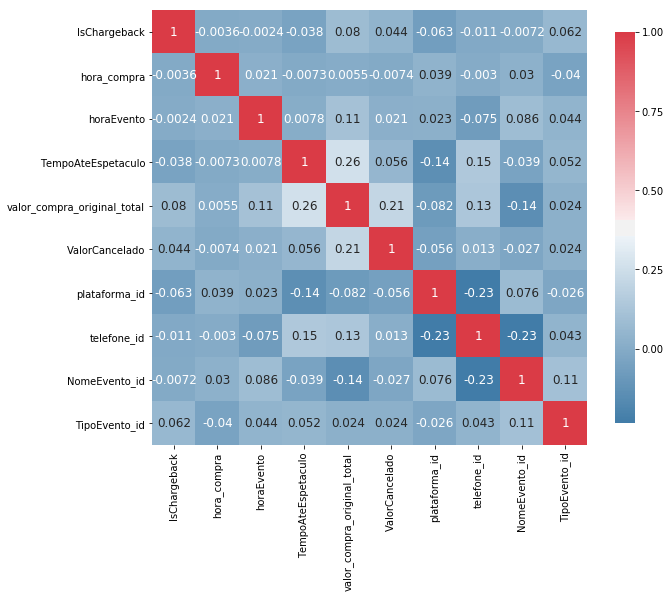

In [20]:
df = df_cbk[['IsChargeback', 'hora_compra', \
       'horaEvento', 'TempoAteEspetaculo', \
        'valor_compra_original_total', 'ValorCancelado', 'plataforma_id', \
       'telefone_id', 'NomeEvento_id', 'TipoEvento_id']]

corr = df.corr()
ay, ax = plt.subplots(figsize =(10, 8))
cmap = sns.diverging_palette(240, 10, as_cmap = True)
ay = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

In [21]:
df.skew()

IsChargeback                    8.710240
hora_compra                    -0.705009
horaEvento                     -1.789616
TempoAteEspetaculo              3.792589
valor_compra_original_total     6.555590
ValorCancelado                 16.969028
plataforma_id                   0.036216
telefone_id                     1.675024
NomeEvento_id                   1.187405
TipoEvento_id                   1.517441
dtype: float64

### Separando os dados de treino e teste 

In [22]:
# Target and Features 
# 1 Hundred sample for each. 

df2 = df.loc[df['IsChargeback'] == 1].sample(1000).append(df.loc[df['IsChargeback'] == 0].sample(1000)).sample(2000)
X1 = df2.drop('IsChargeback', axis=1)
Y1 = df2['IsChargeback']

In [23]:
# Gerando os dados normalizados
scaler = Normalizer().fit(X1)
X1 = scaler.transform(X1)

# Sumarizando os dados transformados
print(X1[0:5,:])

[[  1.71451474e-03   1.71451474e-03   6.85805897e-03   1.64593415e-02
    0.00000000e+00   1.22465339e-04   9.98214976e-01   5.69463825e-02
    3.67396016e-04]
 [  3.69925217e-02   3.94586898e-02   0.00000000e+00   2.46616811e-01
    0.00000000e+00   1.23308406e-02   7.89173796e-02   9.64271732e-01
    7.39850434e-03]
 [  6.50923869e-02   6.83470063e-02   0.00000000e+00   3.25461935e-02
    0.00000000e+00   1.62730967e-02   1.04147819e-01   9.89404281e-01
    0.00000000e+00]
 [  6.48677963e-03   9.48067792e-03   4.98983049e-03   7.02568132e-01
    7.02568132e-01   4.98983049e-04   1.59674576e-02   1.11273220e-01
    1.49694915e-03]
 [  5.56598006e-03   2.64384053e-02   1.94809302e-02   9.48999600e-01
    0.00000000e+00   1.39149501e-03   4.45278405e-02   3.10303388e-01
    4.17448504e-03]]


In [24]:
# Import dos módulos
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

# Define folds
num_folds = 10
num_instances = len(X1)
seed = 7

# folds
kfold = model_selection.KFold(num_folds, True, random_state = seed)

# Create model
modelo = DecisionTreeClassifier(random_state=0)

# fit
modelo.fit(X1, Y1)

# result
resultado = model_selection.cross_val_score(modelo, X1, Y1, cv = kfold, scoring = 'accuracy')

# score
print(modelo.score(X1, Y1))
# accuracy
print("Acurácia: %.3f (%.3f)" % (resultado.mean(), resultado.std()))


0.998
Acurácia: 0.840 (0.026)


### Testando o modelo com dados de exemplo

>A acurácia do modelo treinado está em 84% o que é muito bom a primeira versão com a pouca quantidade de dados de input (variáveis preditoras).

In [25]:
test = df.loc[df['IsChargeback'] == 1].sample(500)
test = test.append(df.loc[df['IsChargeback'] == 0].sample(500))
test = test.sample(1000)

In [26]:
x_test = test.drop('IsChargeback', axis=1)
y_test = test.IsChargeback

x_test = x_test
y_test = y_test

In [27]:
# Gerando os dados normalizados
scaler = Normalizer().fit(x_test)
x_test = scaler.transform(x_test)

# Sumarizando os dados transformados
print(x_test[0:5,:])

[[ 0.05610507  0.04634767  0.02683286  0.83181866  0.          0.00243935
   0.07805923  0.54397525  0.00731805]
 [ 0.17364093  0.19191893  0.          0.73111972  0.          0.04569498
   0.29244789  0.55747878  0.009139  ]
 [ 0.03661206  0.04637527  0.03661206  0.83231407  0.          0.0024408
   0.07810572  0.54429923  0.00732241]
 [ 0.13592553  0.17840226  0.          0.93448804  0.          0.00849535
   0.27185107  0.04247673  0.02548604]
 [ 0.01316586  0.0219431   0.0716808   0.18432205  0.          0.00146287
   0.04681195  0.97866233  0.01609161]]


In [28]:
# Save result from the best model
df_result = DataFrame()
df_result['ValorReal'] = y_test

df_result['ValorPrevisto'] = modelo.predict(x_test)

In [ ]:
df_result.to_csv('result_v1.csv', index=False)

In [29]:
df_result.groupby('ValorPrevisto').size()

ValorPrevisto
0    437
1    563
dtype: int64

In [30]:
df_result.head(30)

,ValorReal,ValorPrevisto
55827,1,1
66651,0,0
21947,1,1
59574,1,1
78078,0,0
13243,1,1
48770,1,1
83130,1,1
68275,1,1
373,0,0


In [ ]:
# Rascunho

# Filtro
#df_cbk.loc[(df_cbk['IsChargeback'] == 0) & (df_cbk['NomeEvento'] == 'GAROTA VIP - Rio de Janeiro')].describe()